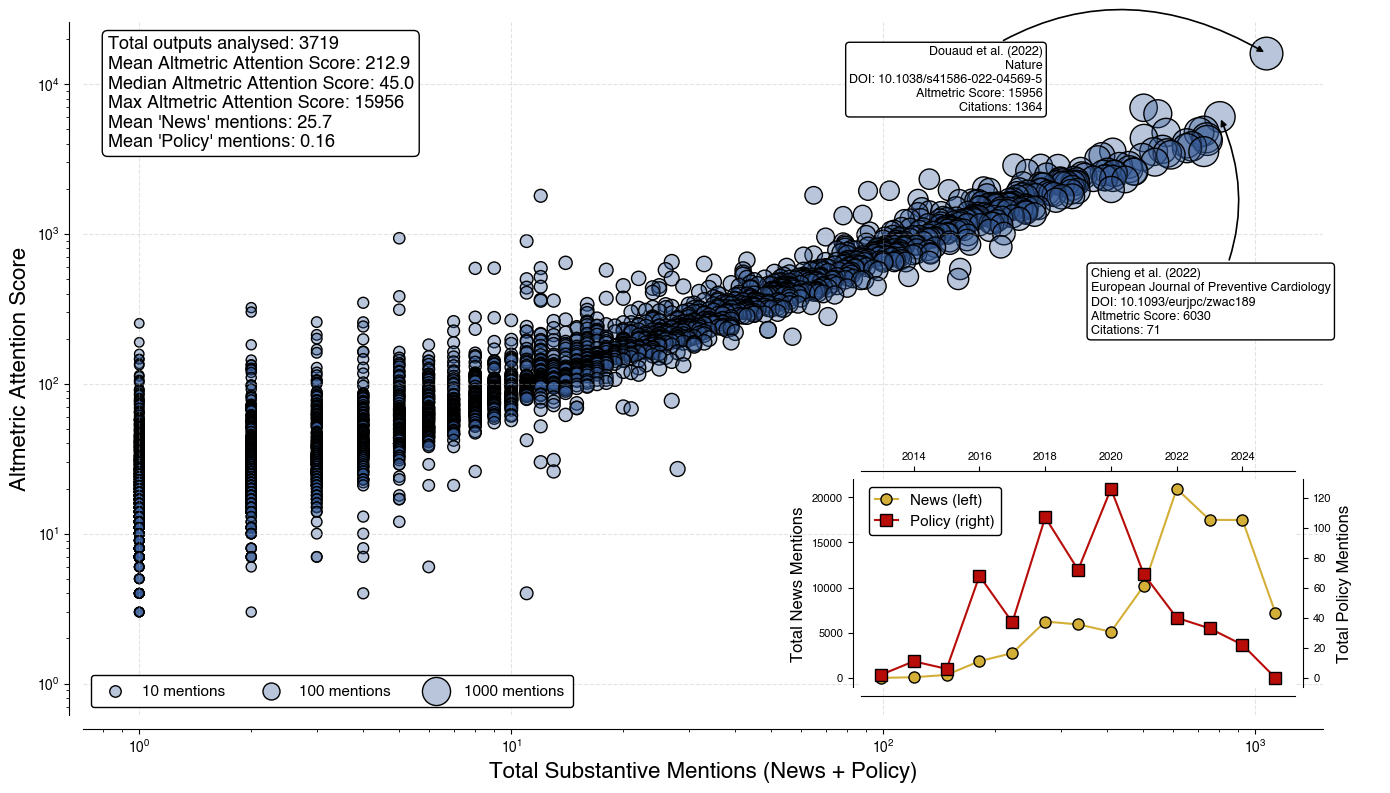

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns
import ast

plt.rcParams['font.family'] = 'Helvetica'

# ================================================================
# 1. LOAD BOTH DATASETS
# ================================================================

df_alt = pd.read_csv("altmetric.csv")
df_dim = pd.read_excel("../data/dimensions/api/raw/combined/202511/df_dimensions.xlsx", index_col=0)

# ================================================================
# 2. CLEAN DOI AND MERGE
# ================================================================

def clean_doi(x):
    if isinstance(x, str):
        return x.strip().lower()
    return np.nan

df_alt["DOI_clean"] = df_alt["DOI"].apply(clean_doi)
df_dim["DOI_clean"] = df_dim["doi"].apply(clean_doi)

df_alt = df_alt.dropna(subset=["DOI_clean"])
df_dim = df_dim.dropna(subset=["DOI_clean"])

# Deduplicate Dimensions: keep most cited entry for each DOI
df_dim = df_dim.sort_values("times_cited", ascending=False)
df_dim = df_dim.drop_duplicates(subset="DOI_clean", keep="first")

# Merge Altmetric + Dimensions
df_merged = df_alt.merge(
    df_dim,
    on="DOI_clean",
    how="left",
    suffixes=("_altmetric", "_dim")
)

# ================================================================
# 3. PREPARE DATA FOR PLOTTING
# ================================================================

df_plot = df_merged.copy()

df_plot["News mentions"] = df_plot["News mentions"].fillna(0)
df_plot["Policy mentions"] = df_plot["Policy mentions"].fillna(0)
df_plot["Altmetric Attention Score"] = df_plot["Altmetric Attention Score"].fillna(0)

df_plot["Total Substantive Mentions"] = (
    df_plot["News mentions"] + df_plot["Policy mentions"]
)

df_plot["Publication Date"] = pd.to_datetime(df_plot["Publication Date"], errors="coerce")
df_plot["Year"] = df_plot["Publication Date"].dt.year

df_scatter = df_plot[
    (df_plot["Total Substantive Mentions"] > 0) &
    (df_plot["Altmetric Attention Score"] > 0)
]

yearly = df_plot.groupby("Year").agg({
    "News mentions": "sum",
    "Policy mentions": "sum"
}).dropna()

# ================================================================
# 4. SUMMARY STATISTICS (TOP LEFT BOX)
# ================================================================

n_outputs = len(df_scatter)
mean_aas = df_scatter["Altmetric Attention Score"].mean()
median_aas = df_scatter["Altmetric Attention Score"].median()
max_aas = df_scatter["Altmetric Attention Score"].max()

mean_news = df_scatter["News mentions"].mean()
mean_policy = df_scatter["Policy mentions"].mean()

stats_text = (
    f"Total outputs analysed: {n_outputs}\n"
    f"Mean Altmetric Attention Score: {mean_aas:.1f}\n"
    f"Median Altmetric Attention Score: {median_aas:.1f}\n"
    f"Max Altmetric Attention Score: {max_aas:.0f}\n"
    f"Mean 'News' mentions: {mean_news:.1f}\n"
    f"Mean 'Policy' mentions: {mean_policy:.2f}"
)

# ================================================================
# 5. HELPER: EXTRACT FIRST AUTHOR + BUILD ANNOTATION TEXT
# ================================================================

def get_first_author_from_row(row):
    """
    Tries, in order:
    1. Dimensions 'authors' as list of dicts (or JSON string of that).
    2. 'authors' as plain string "Surname, First; S2, F2; ..."
    3. Altmetric 'Authors at my Institution' field.
    """
    first_author = None

    a = row.get("authors", None)

    # 1) authors already a Python list[dict]
    if isinstance(a, list) and len(a) > 0:
        d0 = a[0]
        if isinstance(d0, dict):
            ln = d0.get("last_name") or d0.get("surname") or ""
            fn = d0.get("first_name") or d0.get("given_name") or ""
            first_author = (ln or fn).strip() or None

    # 2) authors as JSON-like string of dicts or a simple string
    if first_author is None and isinstance(a, str) and a.strip():
        s = a.strip()
        if s.startswith("[") and "last_name" in s:
            # JSON-ish list of dicts
            try:
                lst = ast.literal_eval(s)
                if isinstance(lst, list) and lst:
                    d0 = lst[0]
                    if isinstance(d0, dict):
                        ln = d0.get("last_name") or d0.get("surname") or ""
                        fn = d0.get("first_name") or d0.get("given_name") or ""
                        first_author = (ln or fn).strip() or None
            except Exception:
                pass

        if first_author is None:
            # Treat as "Surname, First; S2, F2"
            part = s.split(";")[0]
            if "," in part:
                first_author = part.split(",")[0].strip()
            else:
                first_author = part.split()[0].strip()

    # 3) Fallback: Altmetric 'Authors at my Institution'
    if not first_author:
        a2 = row.get("Authors at my Institution", None)
        if isinstance(a2, str) and a2.strip():
            part = a2.split(";")[0]
            if "," in part:
                first_author = part.split(",")[0].strip()
            else:
                first_author = part.split()[0].strip()

    if not first_author:
        first_author = "Author"

    return first_author


def build_annotation_text(row):
    first_author = get_first_author_from_row(row)

    year = row.get("Year")
    year_str = f"{int(year)}" if pd.notna(year) else "n.d."

    # Prefer Dimensions journal title; fall back to Altmetric
    journal = row.get("journal_title_raw")
    if not isinstance(journal, str) or not journal.strip():
        journal = row.get("Journal/Collection Title", "")
    journal = journal if isinstance(journal, str) else ""

    doi = row.get("DOI", "")
    aas = row["Altmetric Attention Score"]

    cites = row.get("times_cited")
    if pd.isna(cites) and "Number of Dimensions citations" in row:
        cites = row["Number of Dimensions citations"]
    cites_str = "NA" if pd.isna(cites) else f"{int(cites)}"

    txt = (
        f"{first_author} et al. ({year_str})\n"
        f"{journal}\n"
        f"DOI: {doi}\n"
        f"Altmetric Score: {aas:.0f}\n"
        f"Citations: {cites_str}"
    )
    return txt

# ================================================================
# 6. PLOT (MAIN FIGURE)
# ================================================================

fig, ax = plt.subplots(figsize=(16, 9))

ax.scatter(
    df_scatter["Total Substantive Mentions"],
    df_scatter["Altmetric Attention Score"],
    s=30 + 16*np.sqrt(df_scatter["Total Substantive Mentions"]),
    color=(52/255, 89/255, 149/255, 0.35),
    edgecolor="k"
)

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("Total Substantive Mentions (News + Policy)", fontsize=16)
ax.set_ylabel("Altmetric Attention Score", fontsize=16)

# Statistics box
ax.text(
    0.02, 0.98, stats_text,
    transform=ax.transAxes,
    fontsize=13,
    va='top', ha='left',
    bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='k', lw=1)
)

# Outward ticks/spines
ax.tick_params(axis="both", which="both", direction="out")
for spine in ax.spines.values():
    spine.set_position(("outward", 10))

# ================================================================
# 7. INSET (YEARLY NEWS + POLICY)
# ================================================================

inset = inset_axes(
    ax,
    width="35%",
    height="30%",
    loc="lower right",
    borderpad=2
)

line_news, = inset.plot(
    yearly.index, yearly["News mentions"], markeredgecolor='k',
    color="#D4AF37", marker="o", linewidth=1.5, markersize=8,
    label="News (left)"
)
inset.set_ylabel("Total News Mentions", fontsize=12)
inset.tick_params(axis="y", labelsize=8)

inset.tick_params(axis="both", which="both", direction="out")
for spine in inset.spines.values():
    spine.set_position(("outward", 6))

ax2 = inset.twinx()
line_policy, = ax2.plot(
    yearly.index, yearly["Policy mentions"], markeredgecolor='k',
    color="#B80C09", marker="s", linewidth=1.5, markersize=8,
    label="Policy (right)"
)
ax2.set_ylabel("Total Policy Mentions", fontsize=12)
ax2.tick_params(axis="y", labelsize=8)
ax2.spines["right"].set_position(("outward", 6))

inset.xaxis.set_label_position("top")
inset.xaxis.tick_top()
inset.tick_params(axis="x", bottom=False, labelsize=8)

inset.grid('')
ax2.grid('')

inset.legend(
    handles=[line_news, line_policy],
    loc="upper left",
    fontsize=11,
    frameon=True,
    fancybox=True,
    edgecolor='k',
    framealpha=1,
    borderpad=0.4,
    handlelength=1.5,
)

# ================================================================
# 8. ANNOTATE TOP TWO PAPERS (CURVED ARROWS)
# ================================================================

top2 = df_scatter.nlargest(2, "Total Substantive Mentions")

# First: above-left
p1 = top2.iloc[0]
ax.annotate(
    build_annotation_text(p1),
    xy=(p1["Total Substantive Mentions"], p1["Altmetric Attention Score"]),
    xytext=(p1["Total Substantive Mentions"] *.25,
            p1["Altmetric Attention Score"] * .4),
    fontsize=9,
    ha='right',
    va='bottom',
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="k", lw=1),
    arrowprops=dict(
        arrowstyle="-|>",
        color='k',
        lw=1.2,
        connectionstyle="arc3,rad=-0.35"
    )
)

# Second: below-right
p2 = top2.iloc[1]
ax.annotate(
    build_annotation_text(p2),
    xy=(p2["Total Substantive Mentions"], p2["Altmetric Attention Score"]),
    xytext=(p2["Total Substantive Mentions"] * 0.45,
            p2["Altmetric Attention Score"] * 0.1),
    fontsize=9,
    ha='left',
    va='top',
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="k", lw=1),
    arrowprops=dict(
        arrowstyle="-|>",
        color='k',
        lw=1.2,
        connectionstyle="arc3,rad=0.25"
    )
)

# ================================================================
# 9. MAIN GRID + DESPINE
# ================================================================

ax.grid(True, which="major", linestyle="--", alpha=0.35, zorder=0)
sns.despine(ax=ax)



import matplotlib.lines as mlines

# Example substantive attention values
example_vals = [10, 100, 1000]

# Compute marker sizes using the same rule used in the scatter
example_sizes = [30 + 12*np.sqrt(v) for v in example_vals]

legend_handles = [
    plt.scatter([], [], 
        s=example_sizes[i], 
        color= (52/255, 89/255, 149/255, 0.35), 
        edgecolor=(0,0,0,1),
        label=f"{example_vals[i]} mentions"
    )
    for i in range(len(example_vals))
]

ax.legend(
    handles=legend_handles,
    #title="Circle size shows total\nNews + Policy mentions",
    loc="lower left",
    frameon=True,
    fancybox=True,
    framealpha=1,
    edgecolor="k",
    fontsize=11,
    title_fontsize=12,
    borderpad=0.6,
    ncols=3
)

plt.savefig("../output/figures/impact.pdf", bbox_inches='tight')
plt.savefig("../output/figures/impact.svg", bbox_inches='tight')
plt.savefig("../output/figures/impact.png", bbox_inches='tight', dpi=800)